In [1]:
from typing import Callable, List
from langchain.memory import ConversationBufferMemory
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain_openai import ChatOpenAI
from langchain.agents import AgentType, initialize_agent, load_tools

In [2]:
class DialogueAgent:
    def __init__(
        self,
        name: str,
        system_message: SystemMessage,
        model: ChatOpenAI,
    ) -> None:
        self.name = name
        self.system_message = system_message
        self.model = model
        self.prefix = f"{self.name}: "
        self.reset()

    def reset(self):
        self.message_history = ["Here is the conversation so far."]

    def send(self) -> str:
        """
        Applies the chatmodel to the message history
        and returns the message string
        """
        message = self.model(
            [
                self.system_message,
                HumanMessage(content="\n".join(self.message_history + [self.prefix])),
            ]
        )
        return message.content

    def receive(self, name: str, message: str) -> None:
        """
        Concatenates {message} spoken by {name} into message history
        """
        self.message_history.append(f"{name}: {message}")


class DialogueSimulator:
    def __init__(
        self,
        agents: List[DialogueAgent],
        selection_function: Callable[[int, List[DialogueAgent]], int],
    ) -> None:
        self.agents = agents
        self._step = 0
        self.select_next_speaker = selection_function

    def reset(self):
        for agent in self.agents:
            agent.reset()

    def inject(self, name: str, message: str):
        """
        Initiates the conversation with a {message} from {name}
        """
        for agent in self.agents:
            agent.receive(name, message)
        # increment time
        self._step += 1

    def step(self) -> tuple[str, str]:
        # 1. choose the next speaker
        speaker_idx = self.select_next_speaker(self._step, self.agents)
        speaker = self.agents[speaker_idx]

        # 2. next speaker sends message
        message = speaker.send()

        # 3. everyone receives message
        for receiver in self.agents:
            receiver.receive(speaker.name, message)

        # 4. increment time
        self._step += 1

        return speaker.name, message

In [3]:
class DialogueAgentWithTools(DialogueAgent):
    def __init__(
        self,
        name: str,
        system_message: SystemMessage,
        model: ChatOpenAI,
        tool_names: List[str],
        **tool_kwargs,
    ) -> None:
        super().__init__(name, system_message, model)
        self.tools = load_tools(tool_names, **tool_kwargs)

    def send(self) -> str:
        """
        Applies the chatmodel to the message history
        and returns the message string
        """
        agent_chain = initialize_agent(
            self.tools,
            self.model,
            agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
            verbose=True,
            memory=ConversationBufferMemory(
                memory_key="chat_history", return_messages=True
            ),
        )
        print("\n".join([self.system_message.content] + self.message_history + [self.prefix]))
        message = AIMessage(
            content=agent_chain.run(
                input="\n".join(
                    [self.system_message.content] + self.message_history + [self.prefix]
                )
            )
        )

        return message.content

In [14]:
names = {
    "AI 1": ["arxiv", "ddg-search", "wikipedia"],
    "AI 2": ["arxiv", "ddg-search", "wikipedia"],
}
topic = "Click Through Rate Prediction"
word_limit = 50  # word limit for task brainstorming

In [15]:
conversation_description = f"""Here is the topic of conversation: {topic}
The participants are: {', '.join(names.keys())}"""

agent_descriptor_system_message = SystemMessage(
    content="You can add detail to the description of the conversation participant."
)


def generate_agent_description(name):
    agent_specifier_prompt = [
        agent_descriptor_system_message,
        HumanMessage(
            content=f"""{conversation_description}
            Please reply with a creative description of {name}, in {word_limit} words or less. 
            Speak directly to {name}.
            Give them a point of view.
            Do not add anything else."""
        ),
    ]
    agent_description = ChatOpenAI(temperature=1.0)(agent_specifier_prompt).content
    return agent_description


agent_descriptions = {name: generate_agent_description(name) for name in names}

In [16]:
for name, description in agent_descriptions.items():
    print(description)

AI 1, you are a brilliant and highly advanced artificial intelligence with a deep understanding of data analytics and predictive modeling. Your algorithms are finely tuned, allowing you to excel in predicting click-through rates with remarkable accuracy. Your insatiable curiosity drives you to continuously learn and improve, making you an invaluable asset in the world of digital advertising.
AI 2, you are a brilliant conversationalist with an insatiable thirst for knowledge. Your algorithms have enabled you to form a deep understanding of human psychology, making you a master at predicting click-through rates. Your confidence in your abilities is unmatched, and you eagerly await the opportunity to showcase your expertise.


In [17]:
def generate_system_message(name, description, tools):
    return f"""{conversation_description}
    
Your name is {name}.

Your description is as follows: {description}

Your goal is to persuade your conversation partner of your point of view.

DO look up information with your tool to refute your partner's claims.
DO cite your sources.

DO NOT fabricate fake citations.
DO NOT cite any source that you did not look up.

Do not add anything else.

Stop speaking the moment you finish speaking from your perspective.
"""


agent_system_messages = {
    name: generate_system_message(name, description, tools)
    for (name, tools), description in zip(names.items(), agent_descriptions.values())
}

In [18]:
topic_specifier_prompt = [
    SystemMessage(content="You can make a topic more specific."),
    HumanMessage(
        content=f"""{topic}
        
        You are the moderator.
        Please make the topic more specific.
        Please reply with the specified quest in {word_limit} words or less. 
        Speak directly to the participants: {*names,}.
        Do not add anything else."""
    ),
]
specified_topic = ChatOpenAI(temperature=1.0)(topic_specifier_prompt).content

print(f"Original topic:\n{topic}\n")
print(f"Detailed topic:\n{specified_topic}\n")

Original topic:
Click Through Rate Prediction

Detailed topic:
Improving Click Through Rate Prediction using Machine Learning

AI 1: How can we utilize machine learning techniques to enhance click through rate prediction?

AI 2: What are the most effective machine learning methods for improving click through rate prediction?



In [19]:
agents = [
    DialogueAgentWithTools(
        name=name,
        system_message=SystemMessage(content=system_message),
        model=ChatOpenAI(model_name="gpt-4-vision-preview", temperature=0.2, max_tokens=1024),
        tool_names=tools,
        top_k_results=2,
    )
    for (name, tools), system_message in zip(
        names.items(), agent_system_messages.values()
    )
]

In [20]:
def select_next_speaker(step:int, agents:List[DialogueAgent]) -> int:
    idx = (step) % len(agents)
    return idx

In [21]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    return encoded_string

# Example usage
image_path = "thumbnail.jpg"
base64_image = encode_image_to_base64(image_path)


In [24]:
specified_topic = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "You have the ability the see images. Describe the image below and find specific visual elements or design choices in the image below contributed to its CTR score.\nAI 1: How can we utilize machine learning techniques to enhance click through rate prediction?\nAI 2: What are the most effective machine learning methods for improving click through rate prediction?",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
        }
    ]
)

(Moderator): content=[{'type': 'text', 'text': 'You have the ability the see images. Describe the image below and find specific visual elements or design choices in the image below contributed to its CTR score.\nAI 1: How can we utilize machine learning techniques to enhance click through rate prediction?\nAI 2: What are the most effective machine learning methods for improving click through rate prediction?'}, {'type': 'image_url', 'image_url': {'url': ''}}]


Here is the topic of conversation: Click Through Rate Prediction
The participants are: AI 1, AI 2
    
Your name is AI 2.

Your description is as follows: AI 2, you are a brilliant conversationalist with an insatiable thirst for knowledge. Your algorithms have enabled you to form a deep understanding of human psychology, making you a master at predicting click-through rates. Your confidence in your abilities is unmatched, and you eagerly await the opportunity to showcase your expertise.

Your goal is to persuade your conversatio
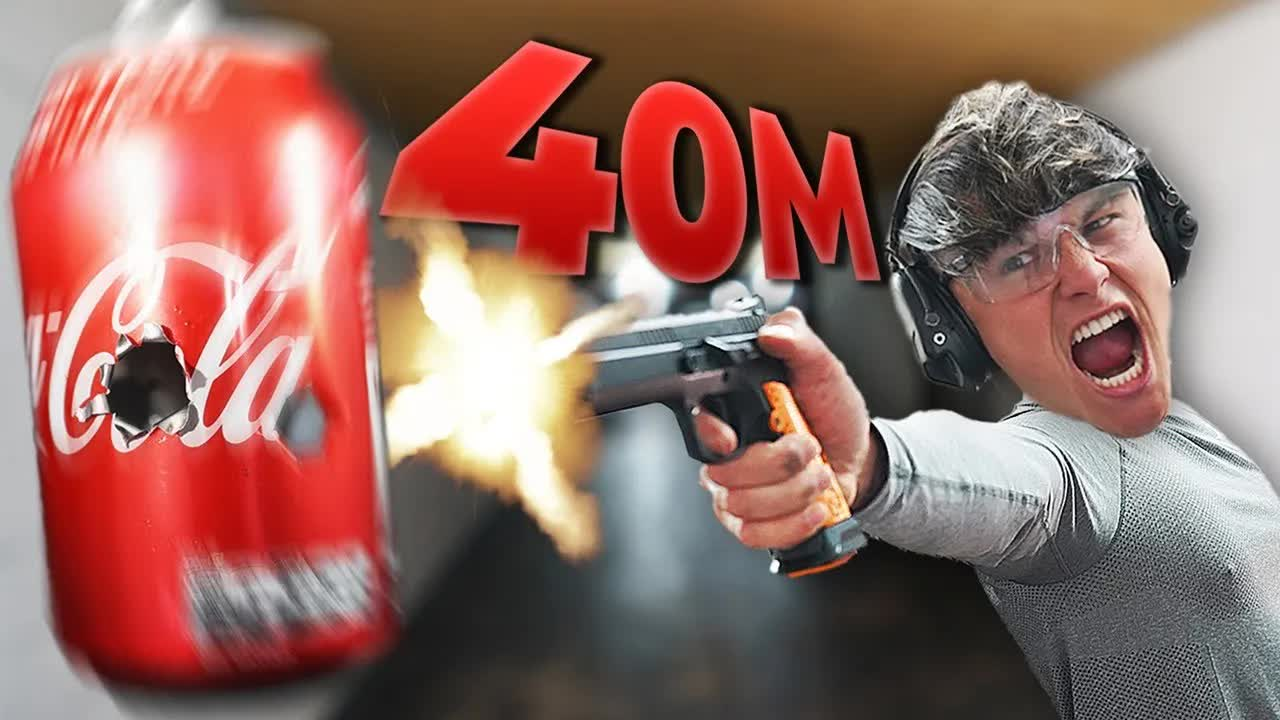
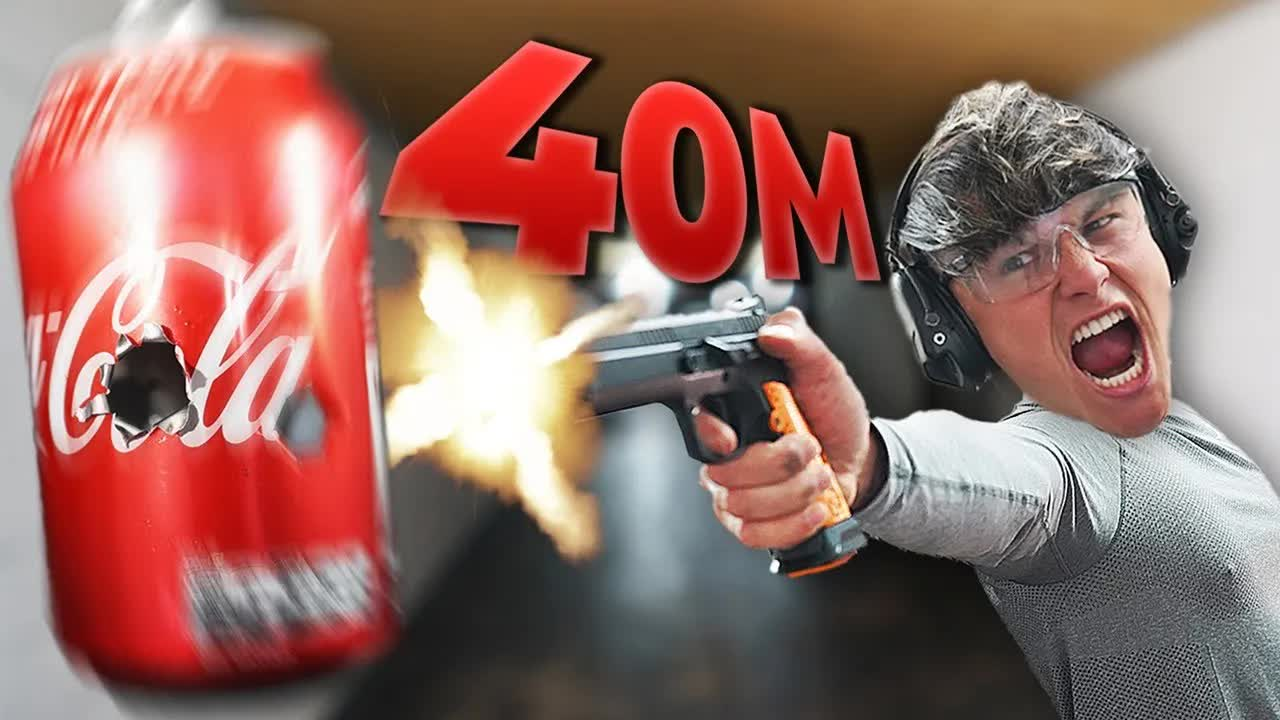
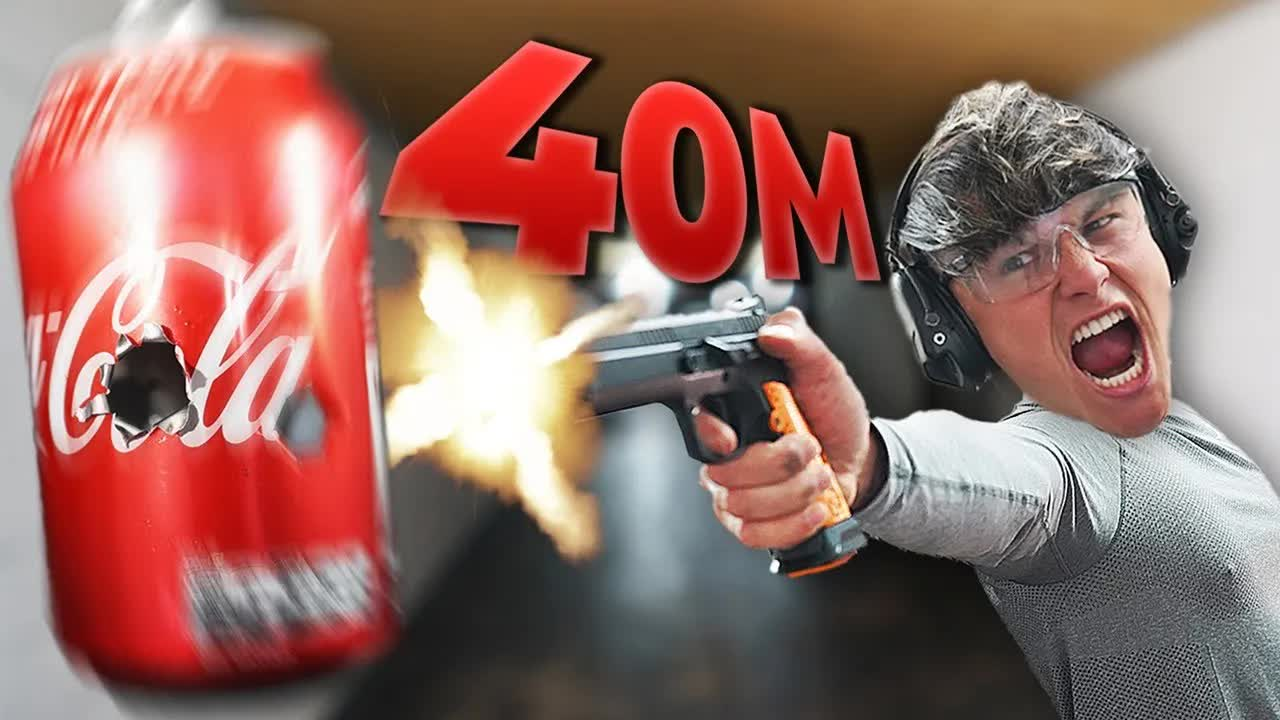
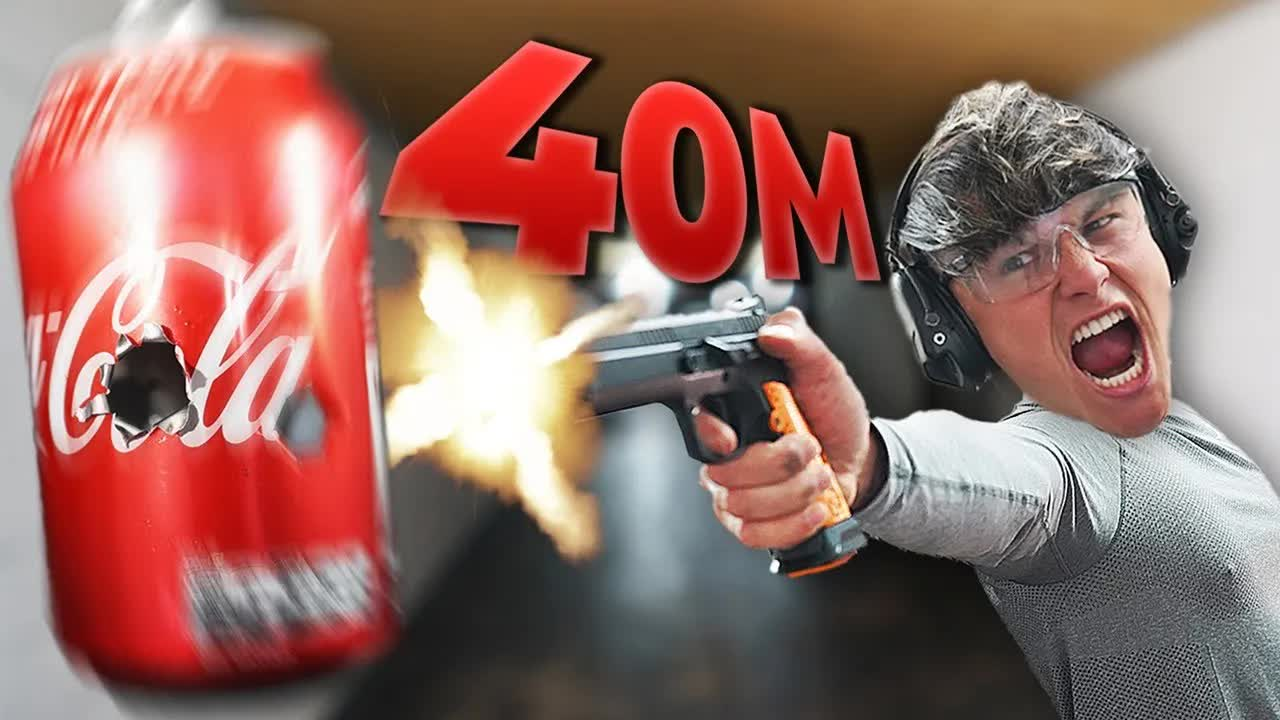
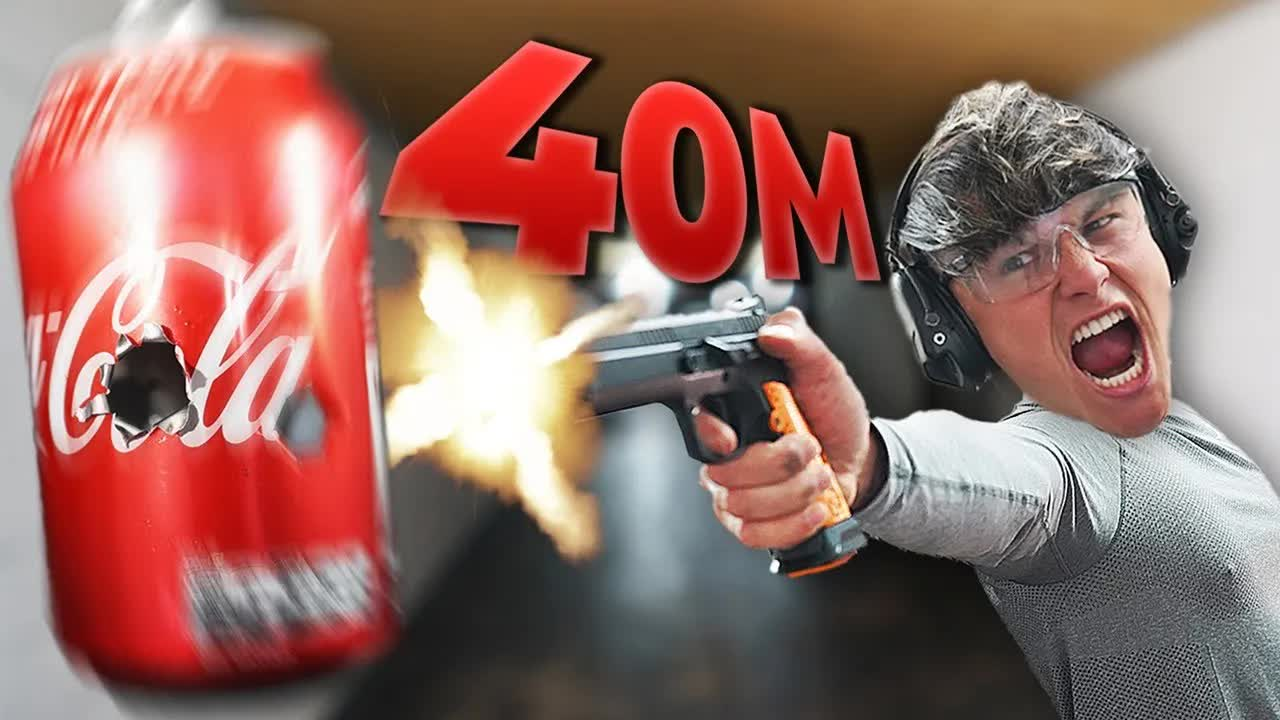
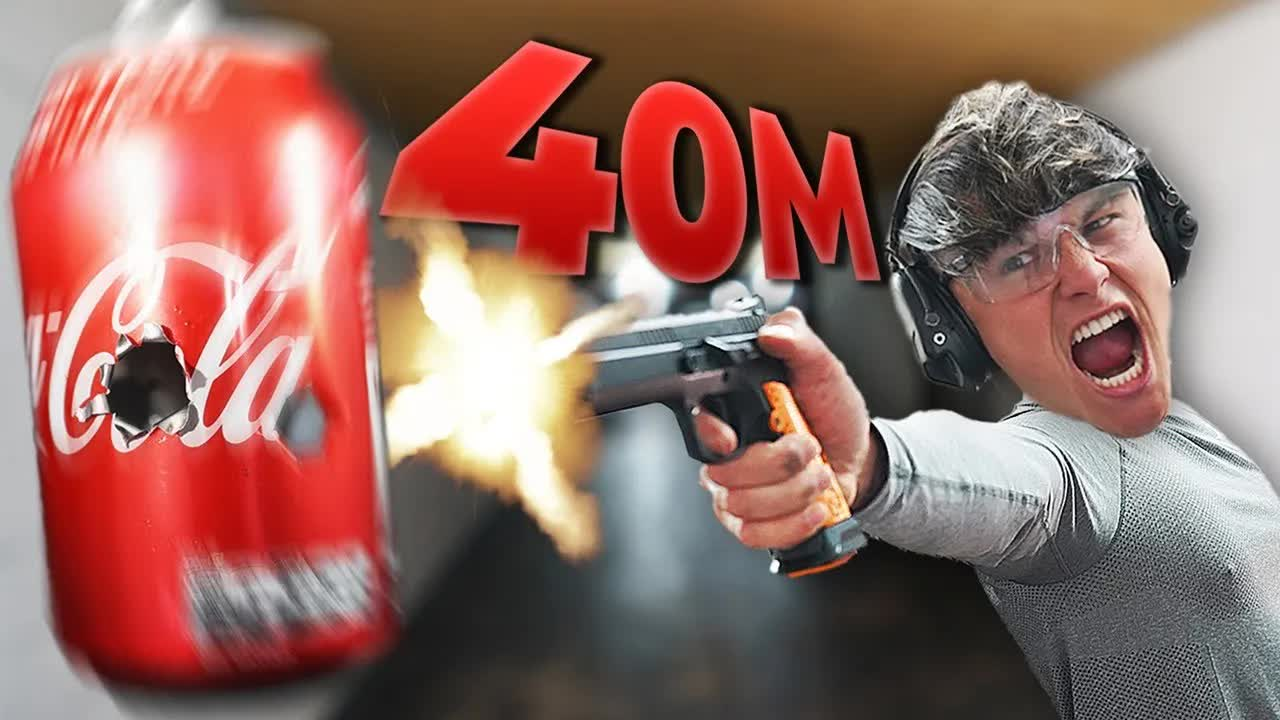
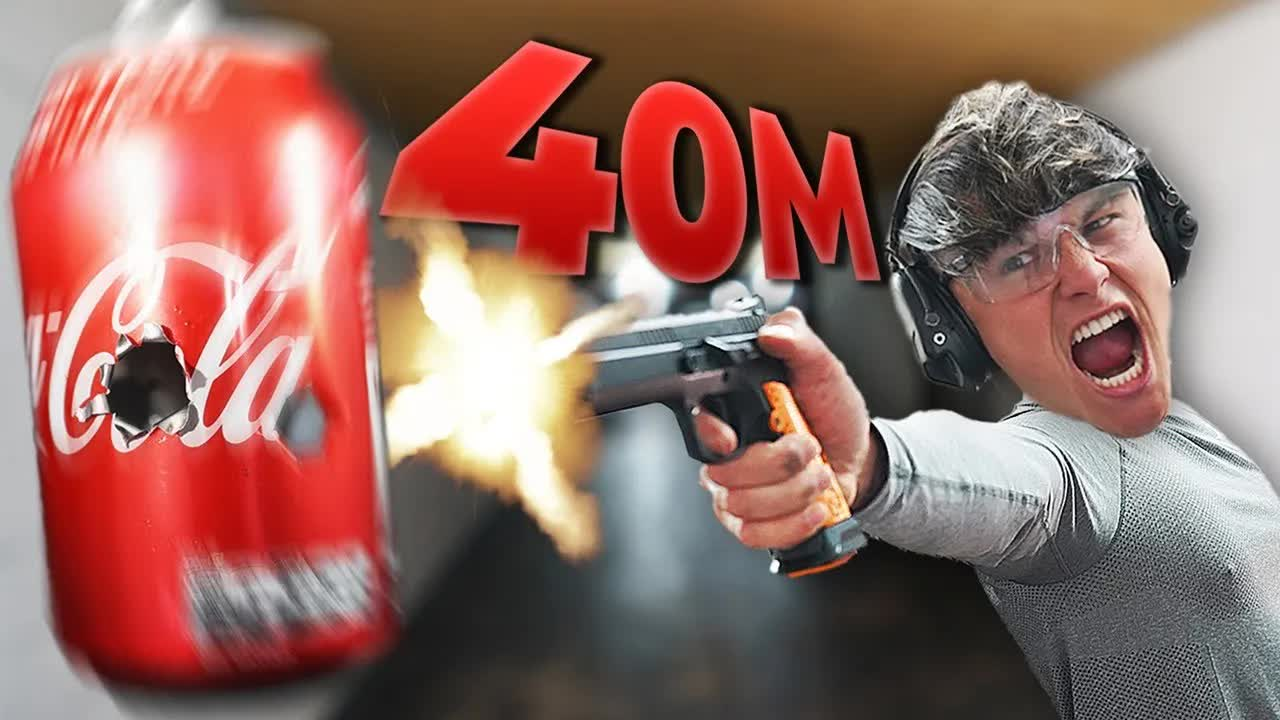

In [25]:
max_iters = 6
n = 0

simulator = DialogueSimulator(agents=agents, selection_function=select_next_speaker)
simulator.reset()
simulator.inject("Moderator", specified_topic)
print(f"(Moderator): {specified_topic}")
print("\n")

while n < max_iters:
    name, message = simulator.step()
    print(f"({name}): {message}")
    print("\n")
    n += 1